# Exercise 21: CNN in PyTorch

PyTorch and other libraries like it use the concept of a TENSOR (multidimensional array of data) to store data
and weights and biases and other things too.

Let's implement a simple CNN in PyTorch. We will try to classify the MNIST handwritten digits dataset.

## Exercise 22!

Try the same thing with cats and dogs!

https://www.kaggle.com/c/dogs-vs-cats


In [ ]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os

import zipfile

#Unzip files to folder
base_dir = '../dogs-vs-cats'
train_dir = '../data/train'
test_dir = '../data/test'
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test1.zip')) as test_zip:
    test_zip.extractall('../data')



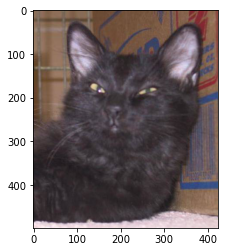

In [6]:
# Create train and test list
import glob
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

# Splitting
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

from PIL import Image

img = Image.open(train_list[14])
#label = train_list[12][1]
plt.imshow(img)
#plt.title('Image with label %d' % (label))
plt.show()

In [7]:
# Create data loaders to load batches of images from the training + validation set stored on disk

train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

class dataset(torch.utils.data.Dataset):

    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

train_data = dataset(train_list, transform=train_transform)
val_data = dataset(val_list, transform=val_transform)
test_data = dataset(test_list, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
val_loader  = DataLoader(val_data, batch_size=100, shuffle=True)


# The CNN model

class CNN_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Create an instance of the model

net = CNN_Model()

#if torch.cuda.is_available:
 #   net = net.cuda()
if torch.cuda.is_available():
    net = net.cuda()
else: net=net.cpu()
# Loss function

criterion = torch.nn.CrossEntropyLoss()

# Optimizer

optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)


## Train Model

In [8]:
# Training loop

num_epochs = 16

train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

for epoch in range(num_epochs):
    # Training set
    epoch_loss = 0
    correct = 0
    iterations = 0
    net.train()
    for i, (inputs, targets) in enumerate(train_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        # Clear out the optimizer's gradient estimates
        optimizer.zero_grad()
        # Forward pass
        outputs = net(inputs)  # like forward() we wrote last week
        loss = criterion(outputs, targets) # loss
        epoch_loss += loss.item()
        loss.backward()  # backprop
        optimizer.step() # adjust weights
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == targets.data).sum()
        iterations += 1
    # Record training loss
    train_loss.append(epoch_loss / iterations)
    # Record training accuracy
    train_acc.append(100 * correct / len(train_loader.dataset))

    # Validation set
    epoch_loss = 0
    correct = 0
    iterations = 0
    
    net.eval()
    for i, (inputs, targets) in enumerate(val_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        # Forward pass
        outputs = net(inputs)  # like forward() we wrote last week
        loss = criterion(outputs, targets) # loss
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == targets.data).sum()
        iterations += 1
        
    # Record validation loss
    valid_loss.append(epoch_loss / iterations)
    # Record validation accuracy
    valid_acc.append(100 * correct / len(val_loader.dataset))
    
    print('Epoch %d/%d, Train loss %.4f, Train acc %.2f, Val loss %.4f, Val acc %.2f' % (
        epoch+1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))

torch.save(net.state_dict(), './net-weights.pth')


Epoch 1/16, Train loss 0.6512, Train acc 61.69, Val loss 0.6949, Val acc 62.76
Epoch 2/16, Train loss 0.6001, Train acc 68.80, Val loss 0.6481, Val acc 69.86
Epoch 3/16, Train loss 0.5828, Train acc 70.76, Val loss 0.5345, Val acc 75.42
Epoch 4/16, Train loss 0.5247, Train acc 75.17, Val loss 0.5712, Val acc 72.74
Epoch 5/16, Train loss 0.4710, Train acc 78.04, Val loss 0.4876, Val acc 77.32
Epoch 6/16, Train loss 0.4517, Train acc 79.65, Val loss 0.4101, Val acc 82.10
Epoch 7/16, Train loss 0.4133, Train acc 81.28, Val loss 0.5629, Val acc 71.90
Epoch 8/16, Train loss 0.4060, Train acc 82.15, Val loss 0.4158, Val acc 81.34
Epoch 9/16, Train loss 0.3938, Train acc 82.58, Val loss 0.4448, Val acc 79.40
Epoch 10/16, Train loss 0.3736, Train acc 83.78, Val loss 0.4003, Val acc 82.04
Epoch 11/16, Train loss 0.3611, Train acc 84.35, Val loss 0.3722, Val acc 83.66
Epoch 12/16, Train loss 0.3669, Train acc 84.14, Val loss 0.4055, Val acc 82.42
Epoch 13/16, Train loss 0.3550, Train acc 85.06, 

<function matplotlib.pyplot.show(close=None, block=None)>

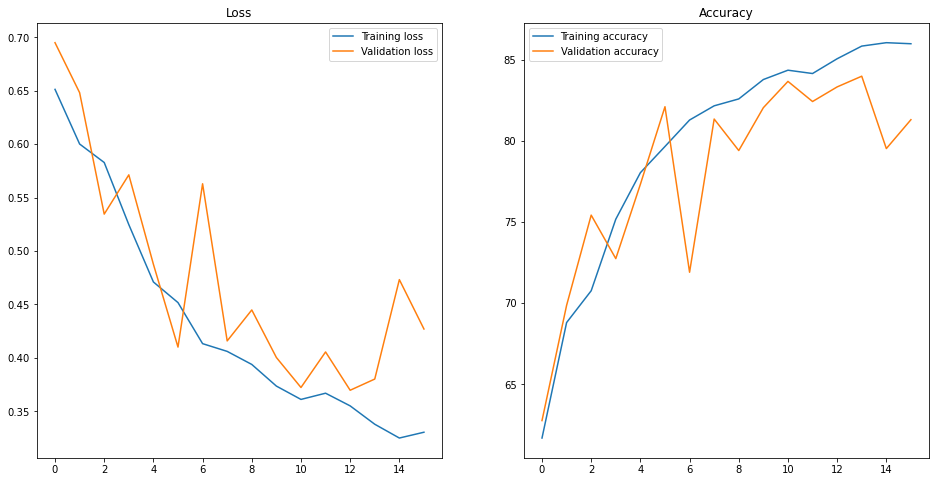

In [12]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in train_acc], label='Training accuracy')
plt.plot([x.cpu() for x in valid_acc], label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show

### Let's check in Validation set!!

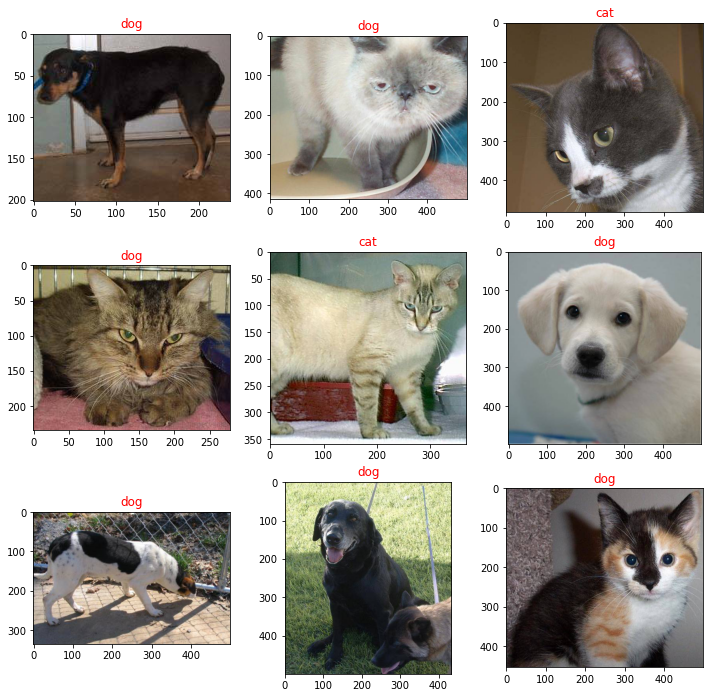

In [15]:
plt.figure(figsize = (12,12))

idx=np.arange(len(val_data))
np.random.shuffle(idx)

for x in range(9):
    im = test_data[idx[x]][0]
    plt.subplot(3,3,x+1)
    img=Image.open(val_list[idx[x]])
    plt.imshow(img)
    #plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
    # CNN Model Prediction:

    net.eval()
    with torch.no_grad():
        new_pred = net(val_data[x][0].view(1,3,224,224)).argmax()

    if int(new_pred)==1:
        pred='dog'
    else:
        pred='cat'
    plt.title(pred,color='red')

In [11]:
def get_label(x):
    return x.split('/')[-1].split('.')[0]

train_labels = [get_label(i) for i in train_list]
val_labels = [get_label(i) for i in val_list]
train_labels.count('dog'), train_labels.count('cat'), val_labels.count('dog'), val_labels.count('cat')

(10012, 9988, 2488, 2512)